# 프로젝트 : 폐렴 진단기 성능개선 하기


#### 캐글의 Chest X-Ray Images 데이터 사용
- 5,856 개의 X-Ray 이미지(JPEG)와 2 개의 범주 (폐렴 / 정상)가 있음
- 광저우 여성 및 어린이 병원의 1~5 세 소아 환자의 흉부 X선 영상
- 데이터 수가 적음 
------------------------------------------------------------------------------------------------------------

**루브릭 평가 기준**

|<center>평가문항</center>|<center>상세기준</center>|
|:------|:------|
|1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.|모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.|
|2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.|regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.|
|3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.|Accuracy 기준 85%에 도달하였다.|




## Step 1. 실험환경 Set-up

라이브러리 준비 

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


## Step 2. 데이터 준비하기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print('train 개수:',len(train_filenames))
print('test 개수:',len(test_filenames))
print('val 개수:',len(val_filenames))

train 개수: 5216
test 개수: 624
val 개수: 16


val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져오기
- tf.io.gfile.glob => 주어진 패턴과 일치하는 파일 목록을 반환
- train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [7]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


파일 경로가 NORMAL, PNEUMONIA로 구분되어 있음 

In [8]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [9]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [10]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [11]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [12]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [13]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [14]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [15]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


### 좌우 반전 augmentation 기법
- 의료 영상 데이터는 충분하지 않은 경우가 많음, augmentation 기법을 사용하여 데이터 수를 늘릴 수 있음
- 하지만 의료 영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있으므로 시도해보는 것은 신중해야 함 

-----------------------------------------------------------------------------------------------------------

### prepare_for_training() 함수를 정의
- Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있음
- shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
- repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용 가능
- batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치
- prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 


In [16]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## Step 3. 데이터 시각화

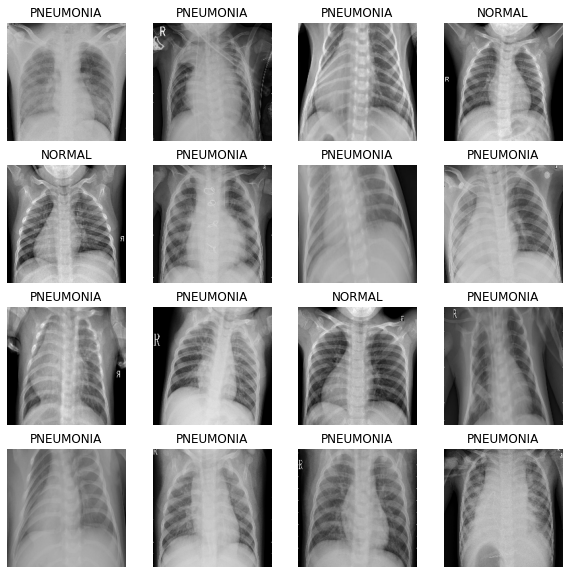

In [17]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### 위의 결과를 보았을 때 좌우 반전이 된 사진들을 볼 수 있다 
- 근육이 연한 회색으로 나오기 때문에 폐 중앙에 있는 것이 심장일 것 같고 심장은 살짝 왼쪽(사진상으로는 오른쪽)으로 치우쳐져 있다. 간혹 오른쪽인 사람도 있지만 매우 드물다. 사진에서 왼쪽으로 치우친 사진은 심장이 오른쪽에 있는거니까 좌우 반전이 된 사진이라 여기면 됨

## Step 4. CNN 모델링

In [18]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [19]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [20]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## Step 5. 데이터 imbalance 처리

In [21]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


## Step 6. 모델 훈련

In [22]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [23]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 80s 196ms/step - loss: 0.3988 - accuracy: 0.7981 - precision: 0.9543 - recall: 0.7654 - val_loss: 0.6307 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 50s 192ms/step - loss: 0.2488 - accuracy: 0.9025 - precision: 0.9733 - recall: 0.8934 - val_loss: 1.2540 - val_accuracy: 0.7385 - val_precision: 0.7385 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 51s 195ms/step - loss: 0.2090 - accuracy: 0.9241 - precision: 0.9791 - recall: 0.9176 - val_loss: 0.2417 - val_accuracy: 0.8760 - val_precision: 0.8567 - val_recall: 0.9987
Epoch 4/25
261/261 [==============================] - 51s 194ms/step - loss: 0.1997 - accuracy: 0.9219 - precision: 0.9744 - recall: 0.9192 - val_loss: 0.2145 - val_accuracy: 0.8923 - val_precision: 0.8723 - val_recall: 1.0000
Epoch 5/25
261/261 [==============================] - 53s 202ms/step - loss: 0.1957 - accura

## Step 7. 결과 확인과 시각화

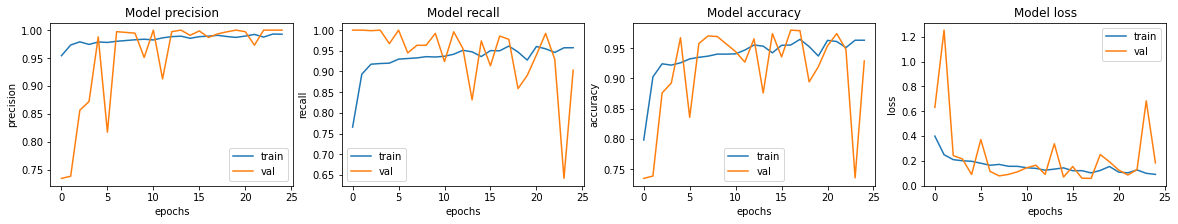

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [25]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 109ms/step - loss: 0.5396 - accuracy: 0.8606 - precision: 0.8451 - recall: 0.9513
Loss: 0.5395795702934265,
Accuracy: 0.8605769276618958,
Precision: 0.8451024889945984,
Recall: 0.9512820243835449


1. 좌우반전 augmentation을 적용하지 않았을 때 결과 
    - Loss: 1.5218251943588257,
    - Accuracy: 0.7419871687889099,
    - Precision: 0.7078039646148682,
    - Recall: 1.0
    

2. 좌우반전 augmentation 적용
    - Loss: 0.5395795702934265,
    - Accuracy: 0.8605769276618958,
    - Precision: 0.8451024889945984,
    - Recall: 0.9512820243835449
    
- Recall 값은 떨어졌지만 그 외에 accuracy와 percision의 값이 10% 이상 증가하였고 loss값도 줄어들어서 향상된 결과값을 보임 
- 결과 시각화 그래프에서 에폭 24에서 결과가 훅 떨어졌다가 다시 올라간 것을 볼 수 있으므로 그 다음 모델을 돌릴때에는 20으로 줄이기
- 데이터 양이 적으므로 배치 사이즈는 늘리지 않고 실행하기 
- 배치 정규화를 안쓰면 어떻게 되는지 확인해보기(dropout은 성능이 확실하기 때문에 빼지 않기로)

## 세번째 모델 적용
- 에폭 20, 배치정규화 제거

In [26]:
BATCH_SIZE = 16
EPOCHS = 20

CNN 모델링

In [30]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block


def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block


def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

모델 훈련

In [31]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [32]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
261/261 [==============================] - 59s 193ms/step - loss: 0.6942 - accuracy: 0.5038 - precision: 0.7441 - recall: 0.5074 - val_loss: 0.6877 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/20
261/261 [==============================] - 49s 190ms/step - loss: 0.6939 - accuracy: 0.5328 - precision: 0.7398 - recall: 0.5733 - val_loss: 0.7051 - val_accuracy: 0.2644 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
261/261 [==============================] - 49s 189ms/step - loss: 0.6942 - accuracy: 0.5510 - precision: 0.7399 - recall: 0.6121 - val_loss: 0.7028 - val_accuracy: 0.2644 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
261/261 [==============================] - 50s 190ms/step - loss: 0.6947 - accuracy: 0.4567 - precision: 0.7377 - recall: 0.4170 - val_loss: 0.6933 - val_accuracy: 0.2625 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
261/261 [==============================] - 50s 193ms/step

이미 그래프로 시각화를 하지 않아도 위의 결과값을 보면 엉망진창이다. 그래도 시각화를 한번 해보았는데 뭔가 규칙성이 보인다?
- 배치 정규화를 제거하니 모든 결과값이 다 안 좋아지는 것을 볼 수 있다. 이 프로젝트에서는 같이 사용하는게 모델 성능 향상에 도움이 되고 꼭 필요하다
- 배치 정규화를 하면 계층을 지나면서 생기는 데이터 오차의 크기를 줄일 수 있는데 배치 정규화를 하지 않으니 그래프 모양이 증가 -> 감소 -> 증가 하는 것을 볼 수 있는데 이 이유는 뭘까?
    - 죽은 ReLu 때문인가? 
    - 학습을 할수록 정규분포를 벗어나고, 분포가 멀어지고, 결국 큰 영향을 미친건가?

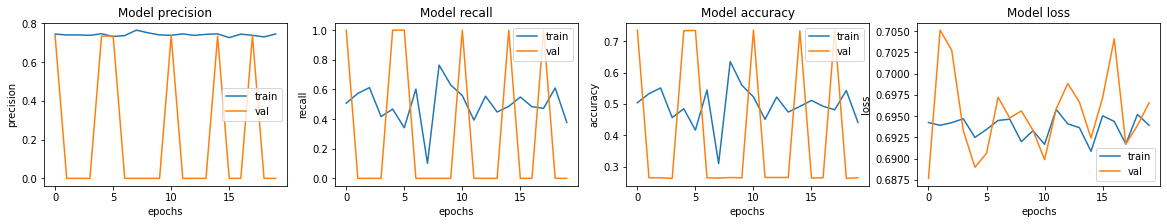

In [33]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

#### 배치 정규화는 미니배치를 단위로  데이터 분포가 평균이 0, 분산이 1이 되도록 정규화 하는 것을 whitening라 함(표준정규분포를 만들어 주는 것은 Standardization)
주목받는 이유
1. 학습을 빨리 진행할 수 있다(learning rate를 크게 잡을 수 있음).
2. 초깃값에 크게 의존하지 않는다(초깃값 선택 장애 개선)
3. 오버피팅을 억제한다(드롭아웃 등의 필요성 감소)

## 네번째 모델 적용
- 배치 정규화 그대로, dropout 제거
- 배치 정규화 자체가 오버피팅을 억제해서 드롭아웃의 필요성이 감소된다고 함
- 얼마나 좋은지 궁금했음

In [34]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block


def dense_block(units):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization()
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        conv_block(128),
        conv_block(256),
        
        tf.keras.layers.Flatten(),
        dense_block(512),
        dense_block(128),
        dense_block(64),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [35]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [36]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
261/261 [==============================] - 59s 190ms/step - loss: 0.2347 - accuracy: 0.9061 - precision: 0.9728 - recall: 0.8989 - val_loss: 0.6339 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/20
261/261 [==============================] - 49s 189ms/step - loss: 0.1617 - accuracy: 0.9373 - precision: 0.9801 - recall: 0.9347 - val_loss: 1.0400 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/20
261/261 [==============================] - 50s 191ms/step - loss: 0.1486 - accuracy: 0.9466 - precision: 0.9816 - recall: 0.9458 - val_loss: 0.1103 - val_accuracy: 0.9654 - val_precision: 0.9946 - val_recall: 0.9583
Epoch 4/20
261/261 [==============================] - 50s 192ms/step - loss: 0.1337 - accuracy: 0.9468 - precision: 0.9829 - recall: 0.9450 - val_loss: 0.0675 - val_accuracy: 0.9779 - val_precision: 0.9818 - val_recall: 0.9882
Epoch 5/20
261/261 [==============================] - 50s 193ms/step - loss: 0.1323 - accura

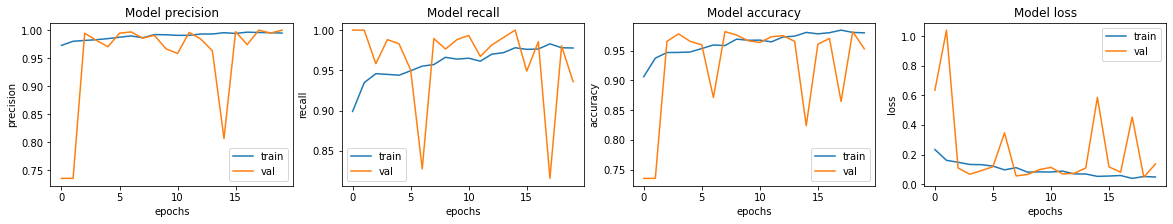

In [37]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [38]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 106ms/step - loss: 0.3989 - accuracy: 0.8910 - precision: 0.8676 - recall: 0.9744
Loss: 0.39887046813964844,
Accuracy: 0.8910256624221802,
Precision: 0.8675799369812012,
Recall: 0.9743589758872986


# 결론 및 회고

#### 첫번쨰와 네번째 모델 비교
1. 좌우반전 augmentation O, 에폭 25, 배치정규화 O, 드롭아웃 O
    - Loss: 0.5395795702934265,
    - Accuracy: 0.8605769276618958,
    - Precision: 0.8451024889945984,
    - Recall: 0.9512820243835449
    
    
2. 좌우반전 augmentation O, 에폭 20, 배치정규화 O, 드롭아웃 X
    - Loss: 0.39887046813964844,
    - Accuracy: 0.8910256624221802,
    - Precision: 0.8675799369812012,
    - Recall: 0.9743589758872986

### 에폭을 줄이고 드롭아웃을 제거하니 더 좋은 성능을 보임(4번째 모델)
- 결과가 나오기 전에는 배치정규화에 드롭아웃까지 하니까 성능이 향상될거라고 생각했는데 좋지 않았다. lms에서 말한 것처럼 두가지를 한번에 사용은 잘하지 않는다는걸 보여줬다. 모델이 더 간결해지기도 했고, 배치정규화가 오버피팅을 잘 잡아주는 것을 볼 수 있었다. 
- 데이터 수가 적을 때 그 수를 증가시키기 위해서 알맞은 방법을 선택하고 적용해야 함 
- whitening(데이터 분포가 평균이 0, 분산이 1이 되도록 정규화 하는 것)이 논문이나 자료에 자주 나와서 뭔가 싶었는데 이번에 공부하면서 알게 됨
- 이번에는 다른 하이퍼파라미터들은 크게 건드리지 않고 중요하게 생각했던 부분들을 먼저 시도해보았다.

# 출처

[배치 정규화](https://sonsnotation.blogspot.com/2020/11/8-normalization.html)